In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from xgboost import XGBRegressor

In [2]:
# Step 1: Data Collection
ticker = '^NSEI'  # NIFTY 50 symbol
nifty_data = yf.download(ticker, start='2015-01-01', end='2024-12-31')


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 2: Data Preprocessing
nifty_data.dropna(inplace=True)

In [4]:
# Data Cleaning
nifty_data = nifty_data[~nifty_data.index.duplicated(keep='first')]
from scipy import stats
z_scores = np.abs(stats.zscore(nifty_data[['Open', 'High', 'Low', 'Close', 'Volume']]))
nifty_data = nifty_data[(z_scores < 3).all(axis=1)]
nifty_data.fillna(method='ffill', inplace=True)

C:\Users\TRINAVA\AppData\Local\Temp\ipykernel_40408\3961854166.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_data.fillna(method='ffill', inplace=True)


In [5]:
# Feature Engineering
nifty_data['Return'] = nifty_data['Close'].pct_change()
nifty_data['SMA_20'] = nifty_data['Close'].rolling(window=20).mean()
nifty_data['SMA_50'] = nifty_data['Close'].rolling(window=50).mean()
nifty_data['RSI'] = 100 - (100 / (1 + nifty_data['Return'].rolling(window=14).mean()))
nifty_data.dropna(inplace=True)

In [6]:
# Remove any remaining NaNs before modeling
nifty_data = nifty_data.fillna(method='ffill').fillna(method='bfill')

C:\Users\TRINAVA\AppData\Local\Temp\ipykernel_40408\3029176946.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_data = nifty_data.fillna(method='ffill').fillna(method='bfill')


In [7]:
# Step 3: Feature Engineering
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI']
X = nifty_data[features]
y = nifty_data['Close'].shift(-1)

In [8]:
# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
# Step 5: Random Forest Model Training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Random Forest Prediction & Evaluation
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test[:-1], rf_pred[:-1]))
rf_r2 = r2_score(y_test[:-1], rf_pred[:-1])

print(f'Random Forest RMSE: {rf_rmse}')
print(f'Random Forest R2 Score: {rf_r2}')


d:\Anaconda\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest RMSE: 3689.4936218569037
Random Forest R2 Score: -1.0565215655607432


In [10]:
# Step 7: XGBoost Model Training
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# XGBoost Prediction & Evaluation
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test[:-1], xgb_pred[:-1]))
xgb_r2 = r2_score(y_test[:-1], xgb_pred[:-1])

print(f'XGBoost RMSE: {xgb_rmse}')
print(f'XGBoost R2 Score: {xgb_r2}')

XGBoost RMSE: 3766.8993162425045
XGBoost R2 Score: -1.1437184810638428


In [11]:
# Step 8: ARIMA Model Training (Fine-tuned)
auto_arima_model = auto_arima(nifty_data['Close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(f'Best ARIMA order: {auto_arima_model.order}')

arima_model = ARIMA(nifty_data['Close'], order=auto_arima_model.order)
arima_result = arima_model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=30180.907, Time=2.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30205.584, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30186.025, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30183.660, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30208.432, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=30181.387, Time=1.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30180.575, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30183.747, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30179.843, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=30179.813, Time=0.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=30181.072, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=30181.491, Time=1.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=30183.064, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=30182.559, Time=0.15 sec

Best model:  ARIMA

d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Step 9: SARIMA Model Training
sarima_model = SARIMAX(nifty_data['Close'], order=auto_arima_model.order, seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)

d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
# ARIMA and SARIMA Prediction
y_test = y_test.fillna(method='ffill').fillna(method='bfill')
arima_pred = arima_result.get_prediction(start=y_test.index[0], end=y_test.index[-1])
arima_pred_mean = arima_pred.predicted_mean

sarima_pred = sarima_result.get_prediction(start=y_test.index[0], end=y_test.index[-1])
sarima_pred_mean = sarima_pred.predicted_mean

arima_rmse = np.sqrt(mean_squared_error(y_test, arima_pred_mean))
arima_r2 = r2_score(y_test, arima_pred_mean)

sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred_mean))
sarima_r2 = r2_score(y_test, sarima_pred_mean)

print(f'ARIMA RMSE: {arima_rmse}')
print(f'ARIMA R2 Score: {arima_r2}')
print(f'SARIMA RMSE: {sarima_rmse}')
print(f'SARIMA R2 Score: {sarima_r2}')

ARIMA RMSE: 224.7561095457013
ARIMA R2 Score: 0.9923656550461668
SARIMA RMSE: 224.04899488519845
SARIMA R2 Score: 0.992413616948084


C:\Users\TRINAVA\AppData\Local\Temp\ipykernel_40408\995746899.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_test = y_test.fillna(method='ffill').fillna(method='bfill')


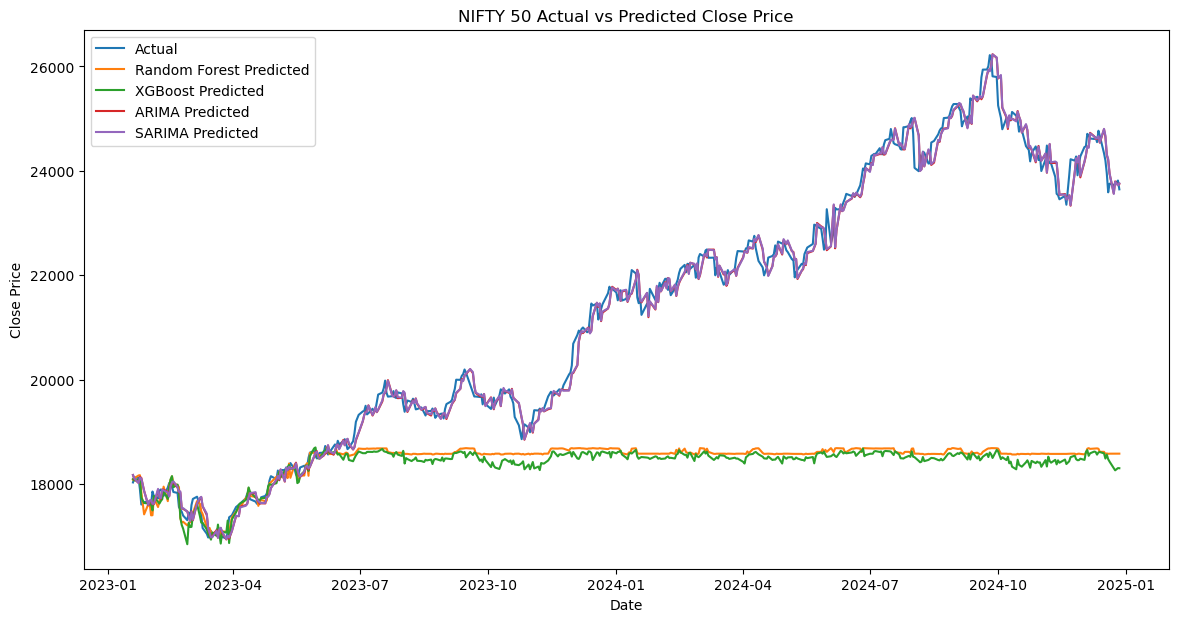

In [14]:
# Step 10: Visualization
plt.figure(figsize=(14, 7))
plt.plot(nifty_data.index[-len(y_test):-1], y_test[:-1], label='Actual')
plt.plot(nifty_data.index[-len(y_test):-1], rf_pred[:-1], label='Random Forest Predicted')
plt.plot(nifty_data.index[-len(y_test):-1], xgb_pred[:-1], label='XGBoost Predicted')
plt.plot(nifty_data.index[-len(y_test):-1], arima_pred_mean[:-1], label='ARIMA Predicted')
plt.plot(nifty_data.index[-len(y_test):-1], sarima_pred_mean[:-1], label='SARIMA Predicted')
plt.title('NIFTY 50 Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [15]:
# Step 11: 3-Year Forecast Using ARIMA and SARIMA
future_steps = 252 * 3
future_index = pd.date_range(start=nifty_data.index[-1], periods=future_steps + 1, freq='B')[1:]

# ARIMA Forecast
arima_forecast = arima_result.get_forecast(steps=future_steps)
arima_forecast_mean = arima_forecast.predicted_mean

# SARIMA Forecast
sarima_forecast = sarima_result.get_forecast(steps=future_steps)
sarima_forecast_mean = sarima_forecast.predicted_mean

d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


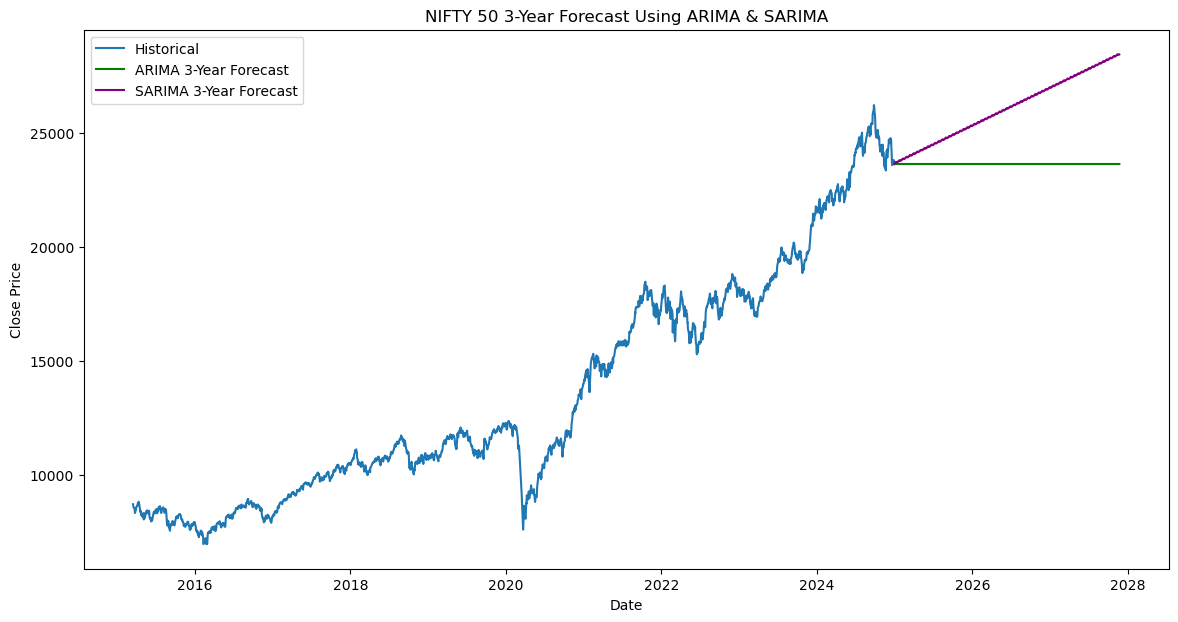

In [16]:
# Plot Future Forecasts
plt.figure(figsize=(14, 7))
plt.plot(nifty_data['Close'], label='Historical')
plt.plot(future_index, arima_forecast_mean, label='ARIMA 3-Year Forecast', color='green')
plt.plot(future_index, sarima_forecast_mean, label='SARIMA 3-Year Forecast', color='purple')
plt.title('NIFTY 50 3-Year Forecast Using ARIMA & SARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()